Проект 2. Анализ данных
Основная цель проекта - получить практику и опыт работы с графическими библиотками python, использовании python для статистического анализа
Задача проекта: выявить факторы, влияющие на результаты госэкзаменов по математике у студентов
Датасет с данными о студентах содержит информацию об их окружении, семье, условиях обучения
Этапы работы: Знакомство с данными, очистка данных, дополнение данных, подготовка данных к стат.анализу, построение гистограмм отсечение лишних признаков, выполнение корреляционного анализа, подготовка заключения по результатам анализа
Промежуточные вывода находятся в комментариях кода
Заключение находится в конце проекта

In [1]:
#Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
%matplotlib inline
#Загрузка датасета
raw_df = pd.read_csv('stud_math.csv')


In [2]:
#Функции для предобработки

#Проверка на наличие пустых значений и заполнение их арифметическим средним
def prepare_float_columns(col,meanround,cut=False,ll=0,hl=0):
    #Есть ли необходимость округлить среднее
    if meanround==True:
        #Округляем
        col_mean = round(col.mean())
    else:
        #Не округляем
        col_mean = col.mean()
    col = col.apply(lambda x: col_mean if pd.isnull(x) else x)
    #Необходимо ли искать выбросы и заменять их на средние значения
    if cut==True:
        #Заданы ли границы отсечения
        if (hl==0 & ll==0):
            #Находим границы выбросов
            q25 = col.quantile(0.25)
            q75 = col.quantile(0.75)
            IQR = q75-q25
            low_limit = q25 - IQR*1.5
            high_limit = q75 + IQR*1.5
        else:
            #границы заданы
            low_limit = ll
            high_limit = hl           
        #Заменяем выбросы на среднее
        col = col.apply(lambda x: col_mean if x<low_limit else x)
        col = col.apply(lambda x: col_mean if x>high_limit else x)
    return col
 
#функция преобразования категориального признака в числовые значения
def get_dummiesM (dfd,colnames):
    #проход по всем полям переданного dataframe
    for col in colnames:
        #получение серии из текущего столбца
        s = pd.Series(dfd[col]).dropna()
        #определение порядкового уникального номера
        nda = s.unique()
        uniq = pd.Series(s.unique())
        #запись уникального номера, если номер ненайден то -1
        dfd[col] = dfd[col].apply(lambda x: -1 if len(uniq[uniq==x].index)==0
                                                else uniq[uniq==x].index[0])
    return dfd 
#Построение боксов для категориальных признаков
def get_boxplot(df,column,maxcount):
    fig, ax = plt.subplots(figsize = (8, 4))
    sns.boxplot(x=column, y='score', 
          data=df.loc[df.loc[:, column].isin(df.loc[:, column].
                value_counts().index[:maxcount])],ax=ax)
    plt.xticks(rotation=0)
    ax.set_title('Boxplot for ' + column)
    plt.show()
#Поиск статистически значимых различий для признаков
def get_stat_dif(df,column,pV):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'], 
                        df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
            <= pV/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break


In [3]:
#Первичная обработка данных
#Общий осмотр

#Проверка на наличие нетипичных данных в сторовых столбцах, обработка
#Оценка количества цникальных значений, где это применимо
raw_df.info()
raw_df.head(10)
raw_df.school.value_counts() # все хорошо
raw_df.sex.value_counts() # все хорошо
raw_df.address.value_counts() # все хорошо, но есть пустые, заполнить нечем
raw_df.famsize.value_counts() # все хорошо, но есть пустые, заполнить нечем
raw_df.Pstatus.value_counts() # все хорошо, но есть пустые, заполнить нечем
raw_df.Mjob.value_counts() # все хорошо, но есть пустые, заполнить нечем
raw_df.Fjob.value_counts() # все хорошо, но есть пустые, заполнить нечем
raw_df.reason.value_counts() # все хорошо, но есть пустые, заполнить нечем
raw_df.guardian.value_counts() # все хорошо, но есть пустые, заполнить нечем
raw_df.schoolsup.value_counts() # все хорошо, но есть пустые, заполнить нечем
raw_df.famsup.value_counts() # все хорошо, но есть пустые, заполнить нечем
raw_df.paid.value_counts() # все хорошо, но есть пустые, заполнить нечем
raw_df.activities.value_counts() # все хорошо, но есть пустые, заполнить нечем
raw_df.nursery.value_counts() # все хорошо, но есть пустые, заполнить нечем
raw_df.higher.value_counts() # все хорошо, но есть пустые, заполнить нечем
raw_df.internet.value_counts() # все хорошо, но есть пустые, заполнить нечем
raw_df.romantic.value_counts() # все хорошо, но есть пустые, заполнить нечем

#Проверка на наличие пустых значений и заполнение их арифметическим средним,
#Если значения поля целые,несмотря на тип float при замене пустых на среднее
#Округляем до целых (2 параметр)
#Удаление выбросов при необходимости (3 парметр функции обработки)
raw_df.age = prepare_float_columns(raw_df.age,True) #выбросов небыло
raw_df.Medu = prepare_float_columns(raw_df.Medu,True) #выбросов небыло
raw_df.Fedu = prepare_float_columns(raw_df.Fedu,True,True,0,4) #выбросы отсечены принудительно
raw_df.traveltime = prepare_float_columns(raw_df.traveltime,True) #выбросов небыло
raw_df.studytime = prepare_float_columns(raw_df.studytime,True) #выбросов небыло
raw_df.failures = prepare_float_columns(raw_df.failures,True) #выбросов небыло
raw_df['studytime, granular']= prepare_float_columns(
    raw_df['studytime, granular'],True,True) #выбросы были

#выбросы будут отсечены принудительно
#работа с номинативными значениями
raw_df.famrel = prepare_float_columns(raw_df.famrel,True,True,1,5)  
raw_df.freetime = prepare_float_columns(raw_df.freetime,True,True,1,5) 
raw_df.goout = prepare_float_columns(raw_df.goout,True,True,1,5) 
raw_df.health = prepare_float_columns(raw_df.health,True,True,1,5)   
raw_df.absences = prepare_float_columns(raw_df.absences,True,True)  
#по стоблцу score обнаружены значения от 0 до 100, 37шт = 0,
#с точки зрения здравого смысла, это имеет место быть, поэтому
#оставляем их без замены на среднее, хотя 0 - это выброс по расчету



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [4]:
#Преобразование номнативных полей в int
raw_df.Medu = raw_df.Medu.astype('int')
raw_df.Fedu = raw_df.Fedu.astype('int')
raw_df.traveltime = raw_df.traveltime.astype('int')
raw_df.studytime = raw_df.studytime.astype('int')
raw_df.famrel = raw_df.famrel.astype('int')
raw_df.freetime = raw_df.freetime.astype('int')
raw_df.goout = raw_df.goout.astype('int')
raw_df.health = raw_df.health.astype('int')



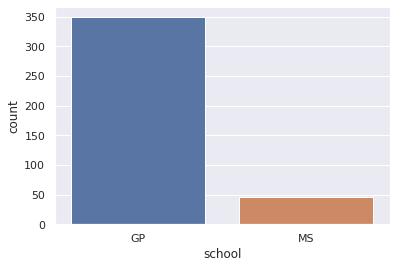

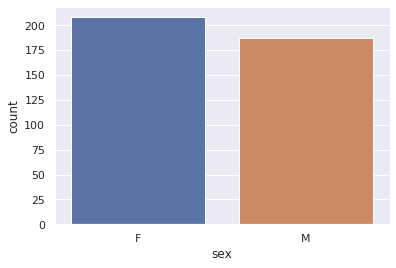

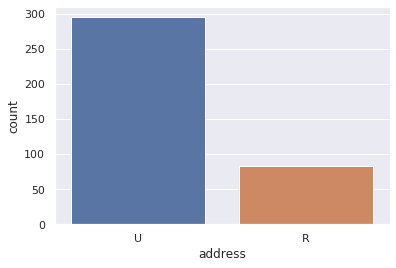

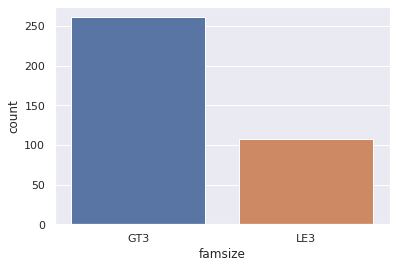

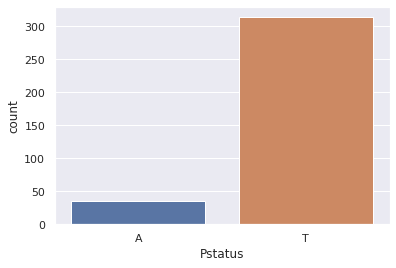

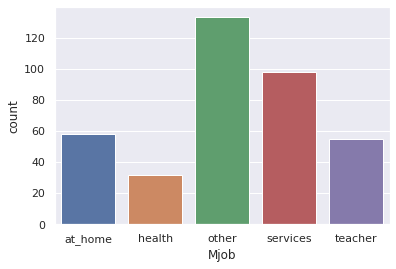

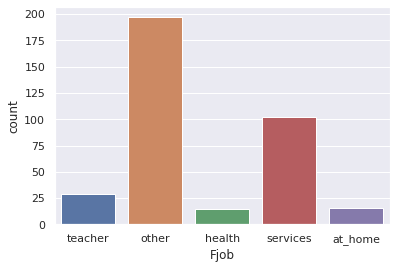

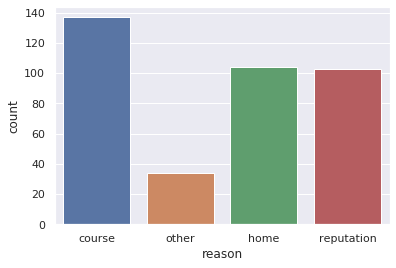

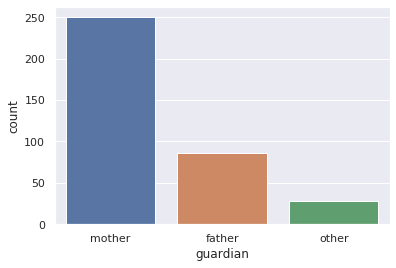

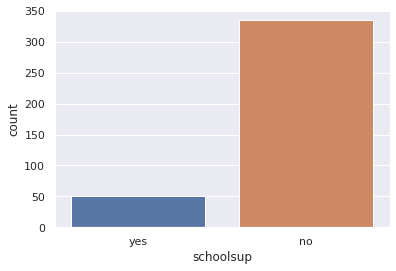

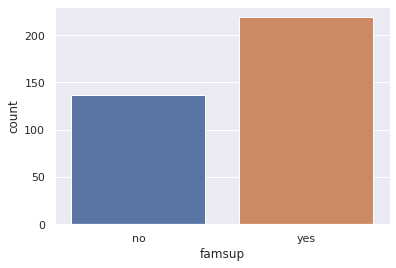

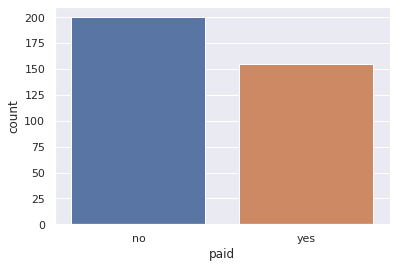

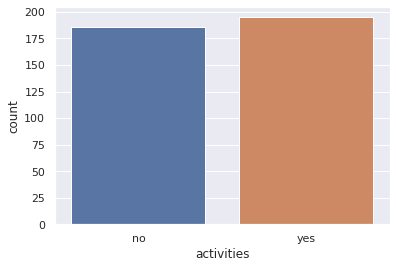

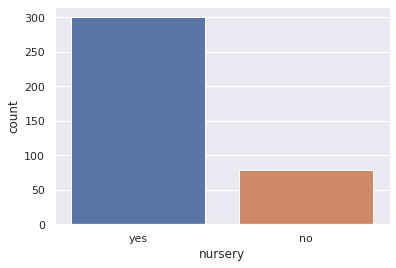

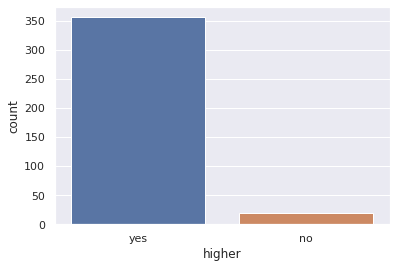

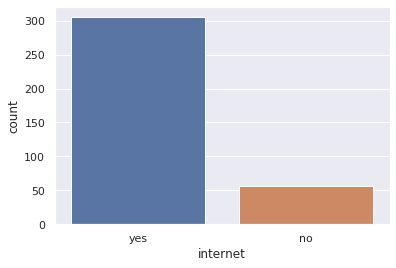

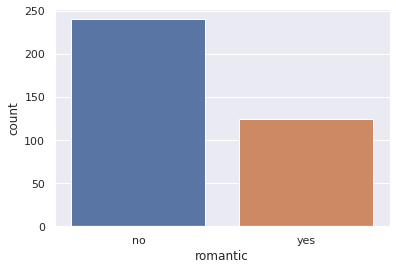

In [5]:
#Визуальный осмотр распределения данных нечисловых полей
sns.set()
for col in raw_df.columns:
    if raw_df[col].dtypes=='object':
        sns.countplot(data=raw_df,x=col)     
        plt.show()


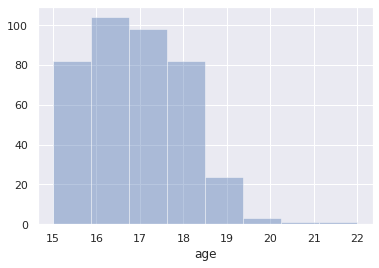

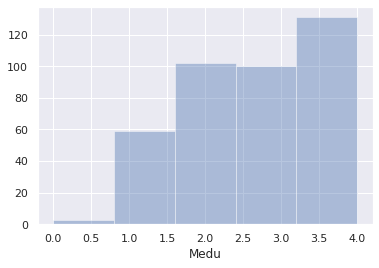

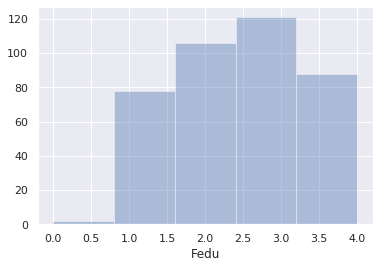

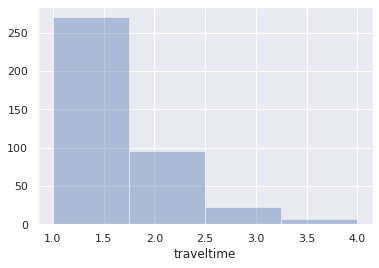

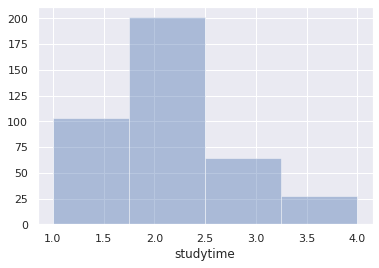

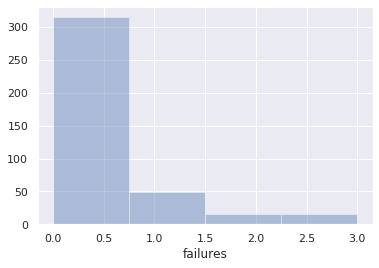

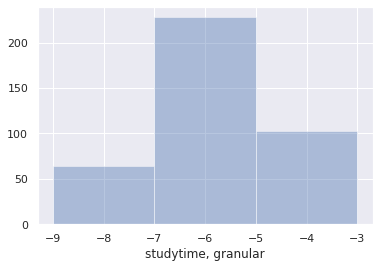

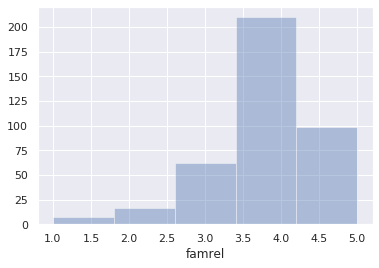

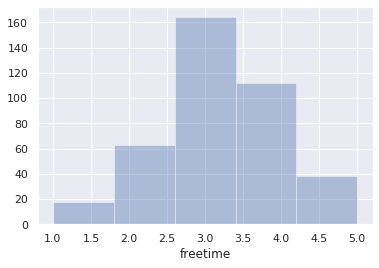

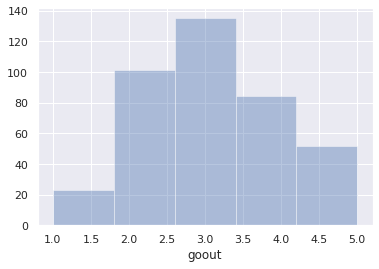

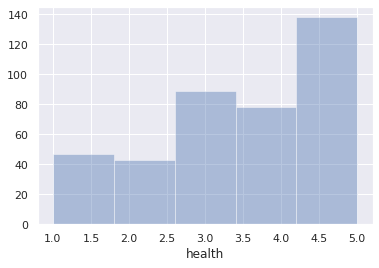

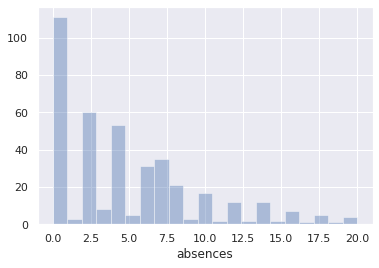

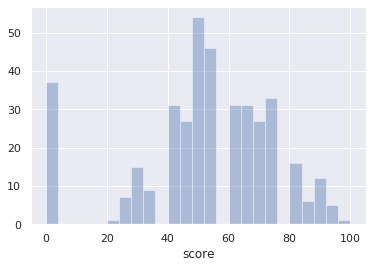

In [6]:
#Визуальный осмотр распределения данных числовых полей
sns.set()
for col in raw_df.columns:
    if raw_df[col].dtypes!='object':
        if col=='score':
            #количество столбиков диаграммы для значения баллов
            binsvalue=25
        else:
            #количество столбиков диаграммы для номинативных значений
            binsvalue=raw_df[col].nunique()
        sns.distplot(raw_df[col],kde=False,bins=binsvalue)     
        plt.show()

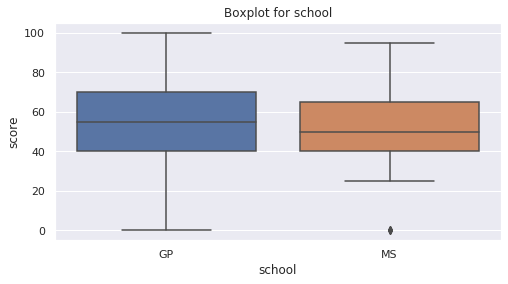

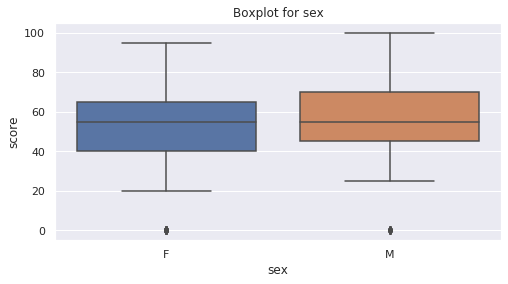

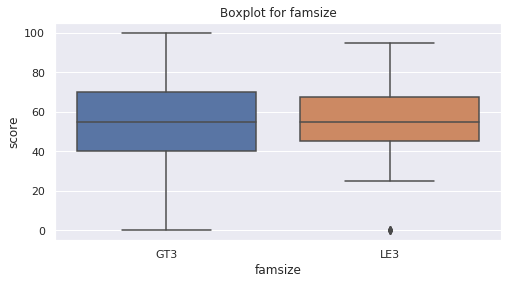

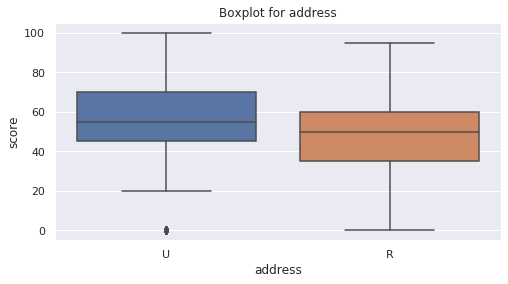

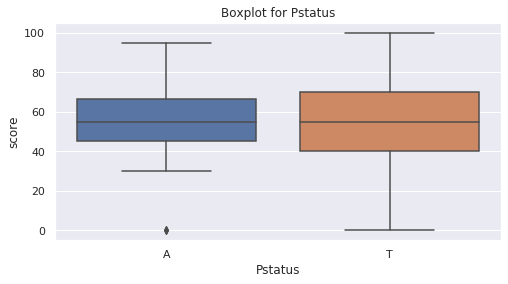

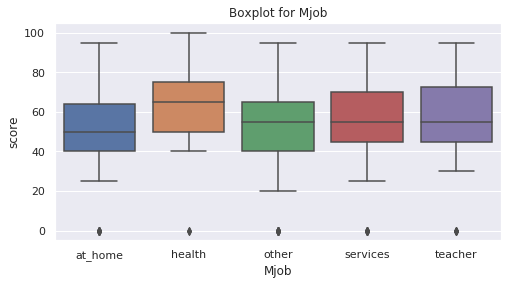

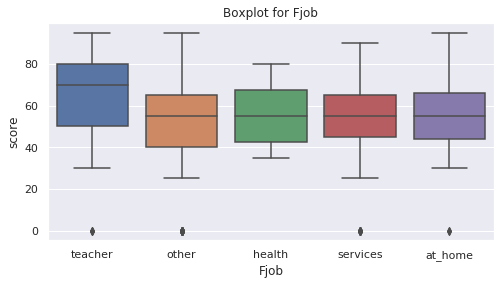

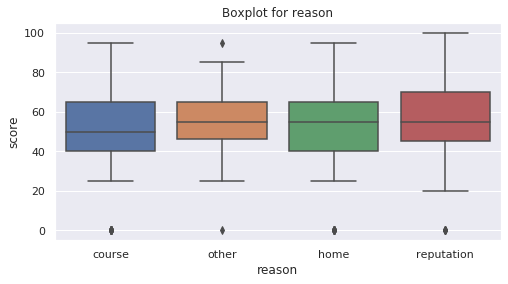

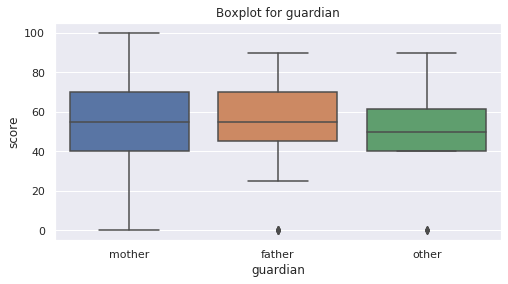

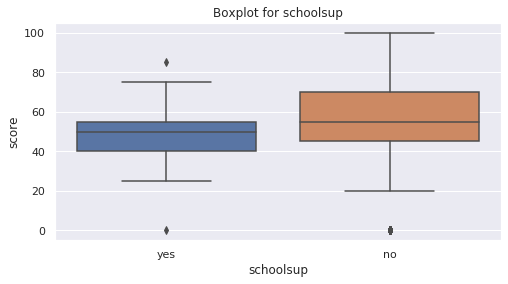

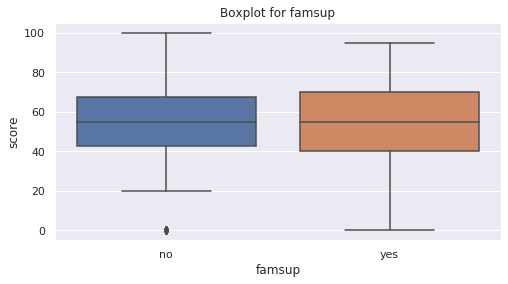

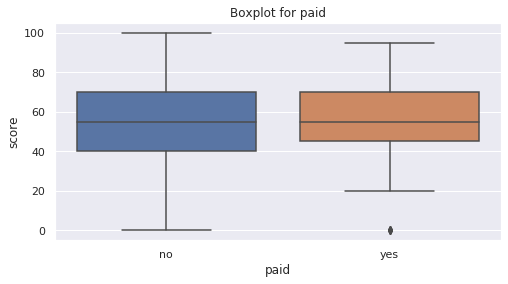

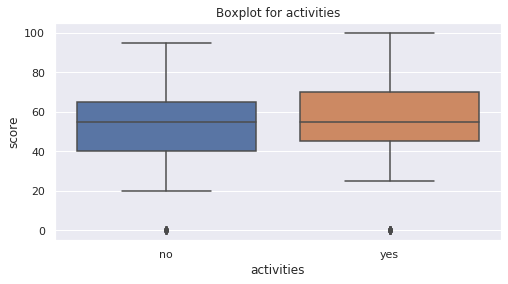

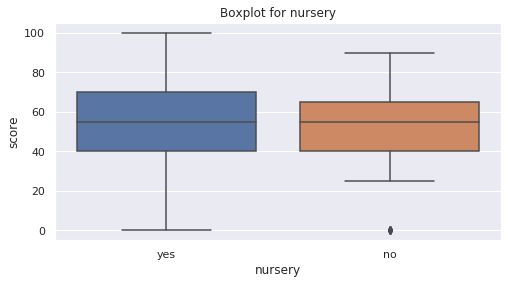

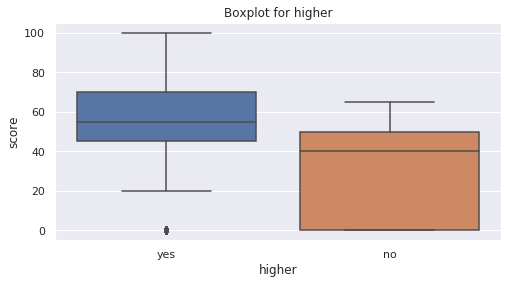

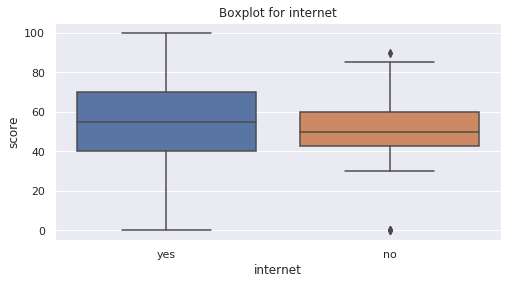

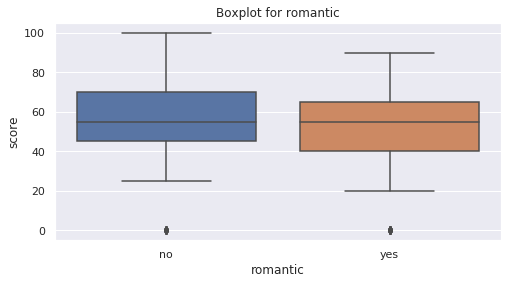

In [7]:
K_columns = ['school','sex', 'famsize','address','Pstatus','Mjob','Fjob',
                            'reason','guardian','schoolsup','famsup','paid',
                            'activities','nursery','higher','internet',
                             'romantic']
#Графический анализ категориальный признаков
for col in K_columns:
    get_boxplot(raw_df,col,30)



In [8]:
for col in K_columns:
    get_stat_dif(raw_df,col,0.1)

Найдены статистически значимые различия для колонки Mjob


/home/olya/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1676: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


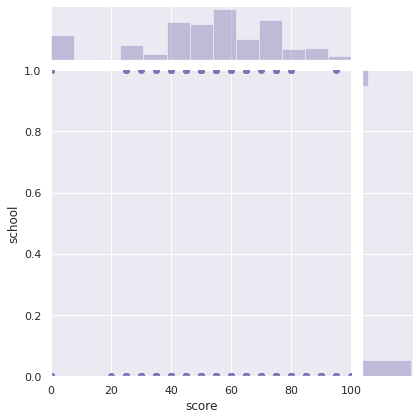

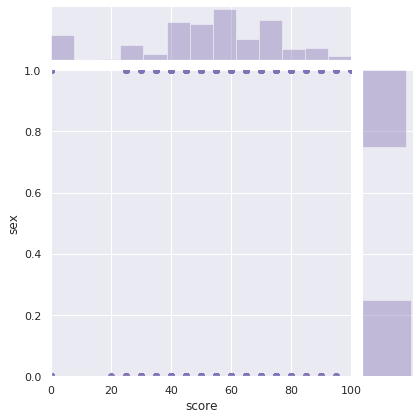

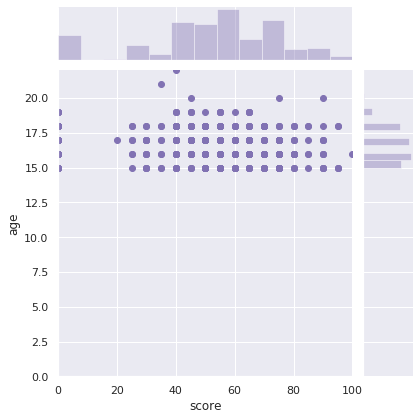

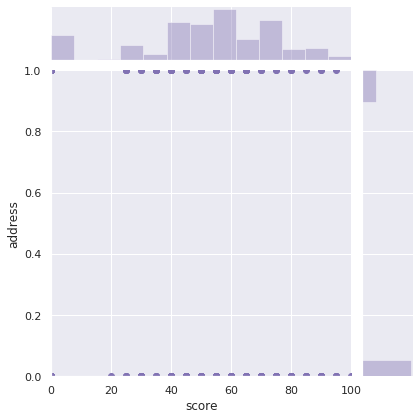

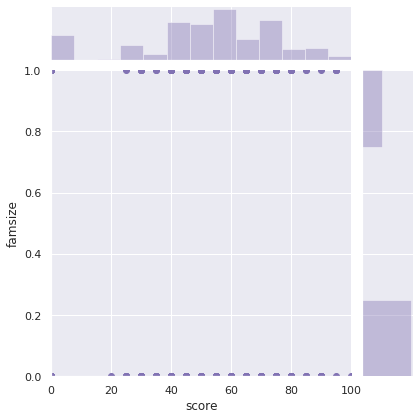

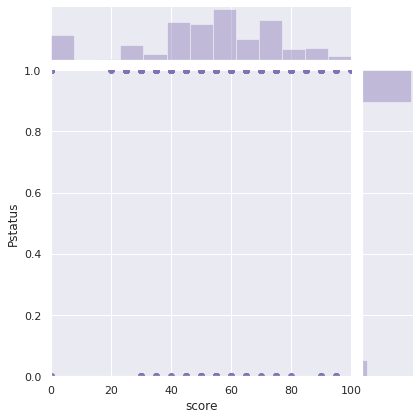

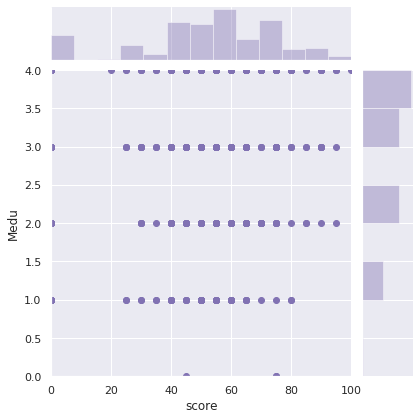

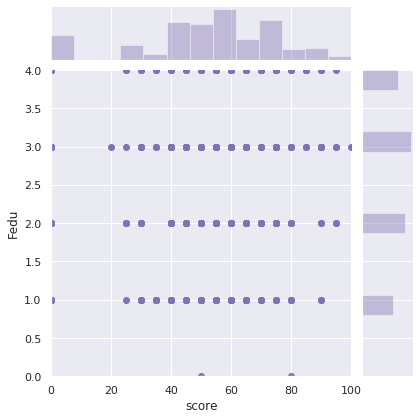

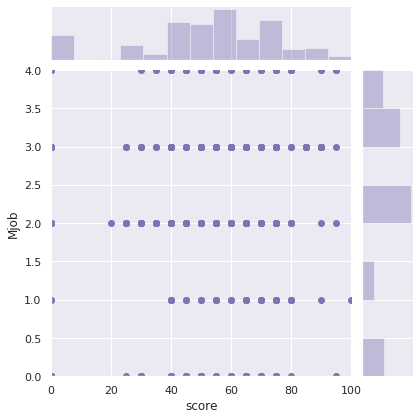

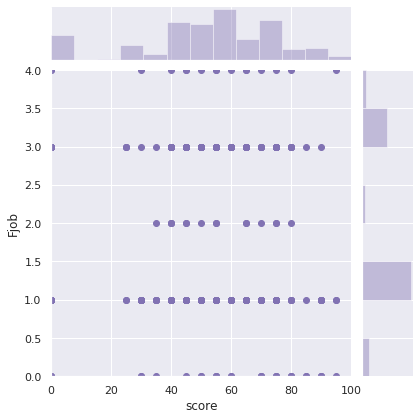

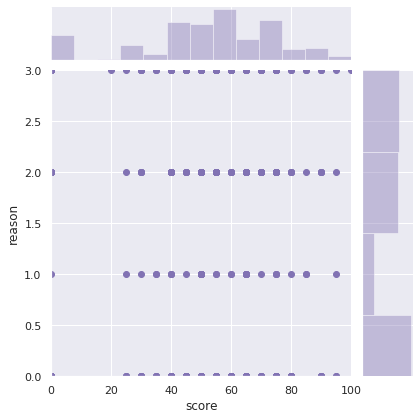

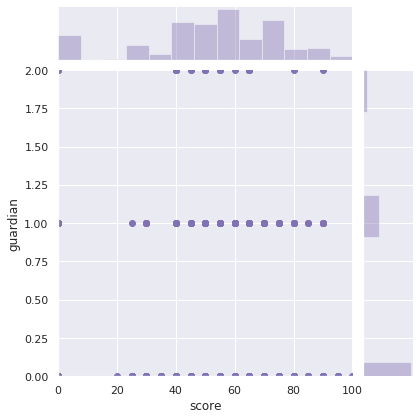

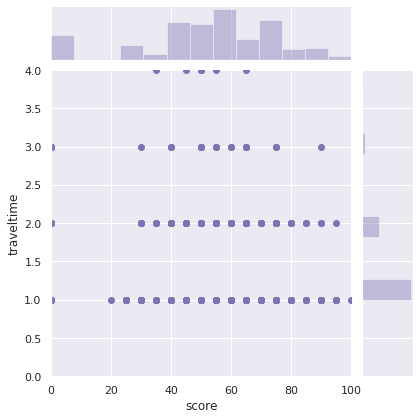

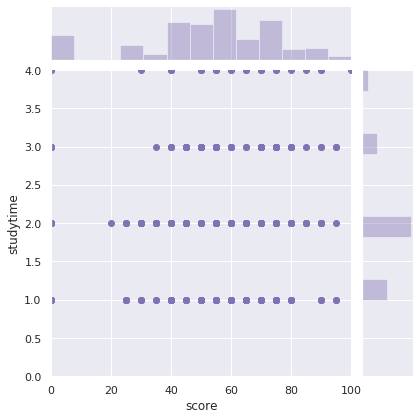

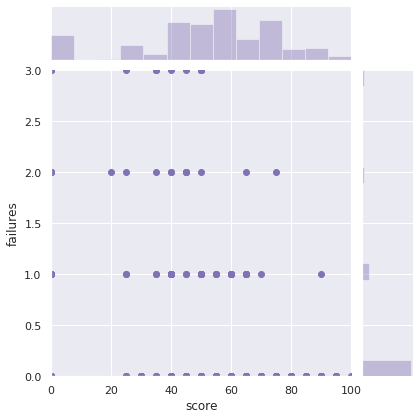

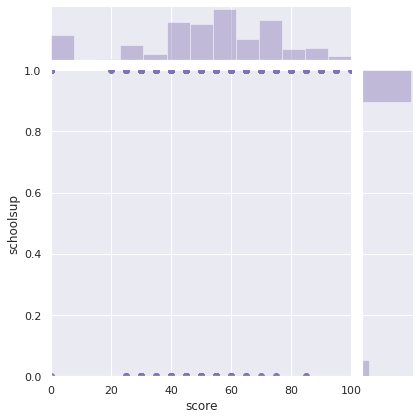

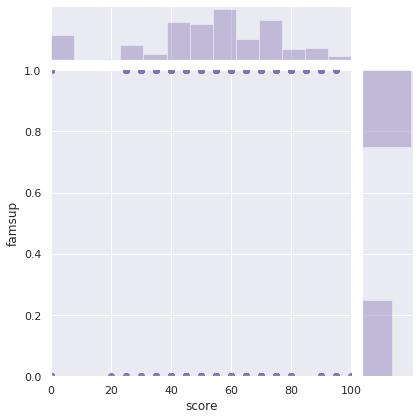

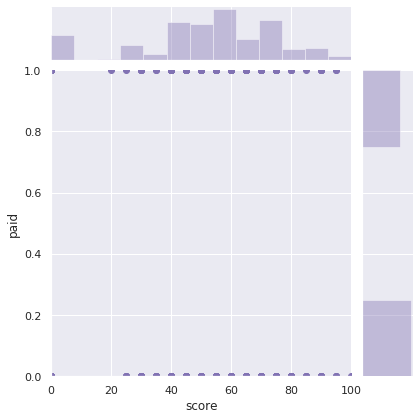

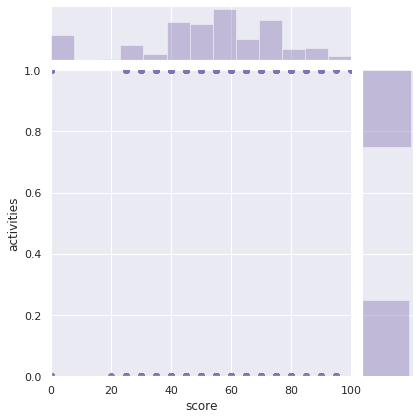

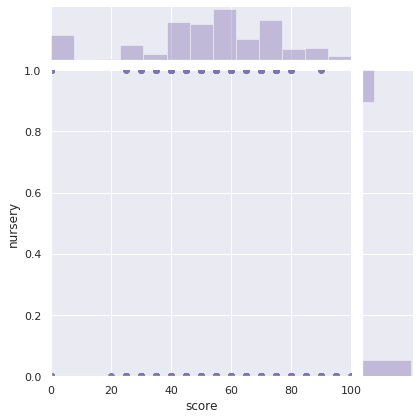

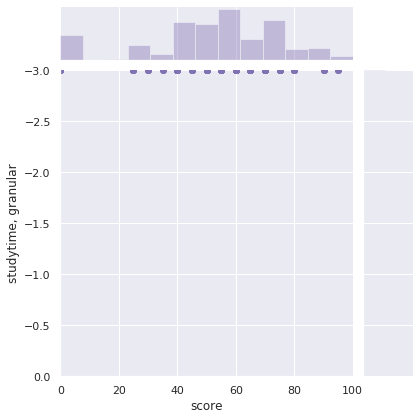

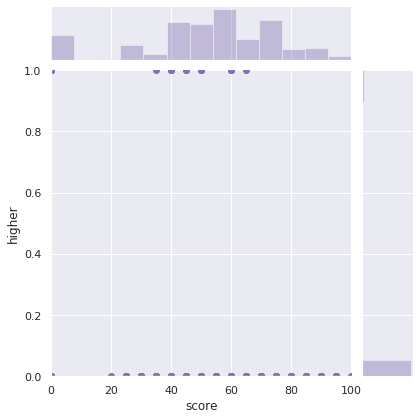

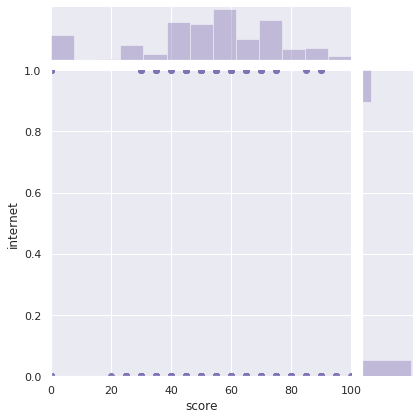

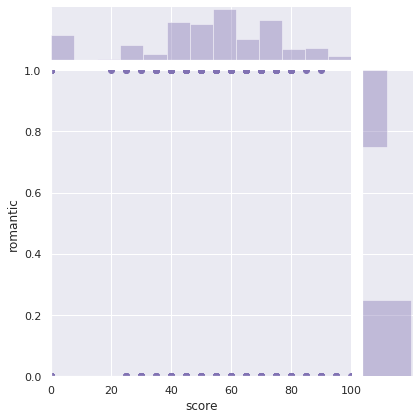

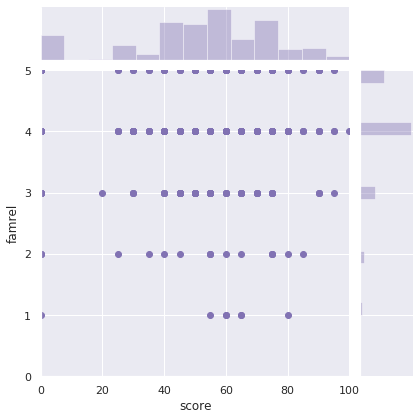

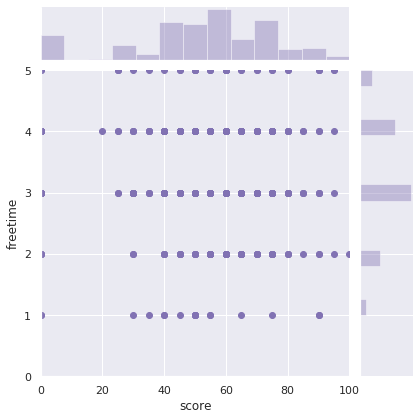

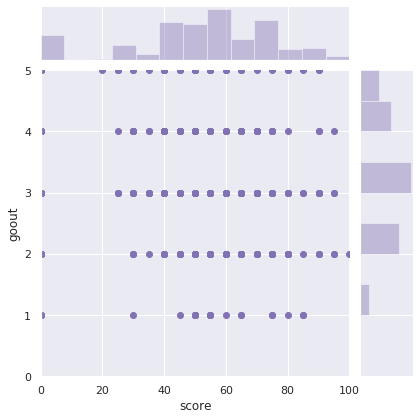

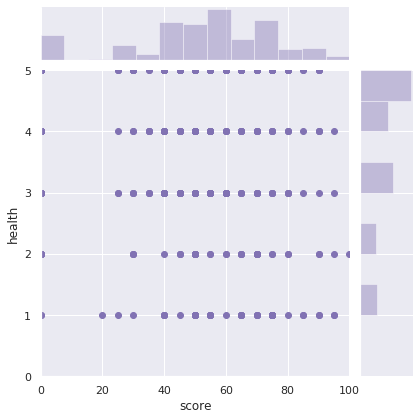

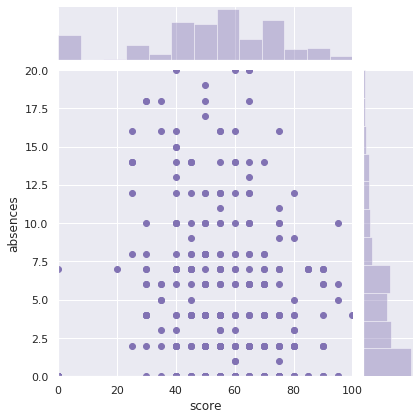

In [9]:
#преобразование категориальных признаков в числовые для построения графиков/КА
raw_df=get_dummiesM (raw_df,K_columns)
#визуализация зависимости score от значений каждого столбца
for col in raw_df.columns:
    if col!='score':
             sns.jointplot(x='score',y=col,data=raw_df,kind='scatter',
                  color='m',xlim=(0,100),ylim=(0,raw_df[col].max()))

In [10]:
#Исходя из представленных диаграмм добавляем удаляем лишние признаки,
raw_df.drop(['sex'], inplace = True, axis = 1)
raw_df.drop(['Fedu'], inplace = True, axis = 1)
raw_df.drop(['Medu'], inplace = True, axis = 1)
raw_df.drop(['Fjob'], inplace = True, axis = 1)
raw_df.drop(['paid'], inplace = True, axis = 1)
raw_df.drop(['activities'], inplace = True, axis = 1)

In [11]:
#корреляционный анализ количественных переменных
corr=raw_df.corr().score

corr[abs(corr)>0.12]

age        -0.155726
address    -0.120265
failures   -0.337187
higher     -0.146401
goout      -0.127742
score       1.000000
Name: score, dtype: float64

Заключение:
Балл на госэкзамене коррелирует с количестом ошибкок/неудач в жизни, более удачливые могут иметь лучший балл. Вообщем неудачники имеют меньшие шансы на прохождение ГЭ, что и следовало ожидать, они же неудачники.

Средне коррелируется желанием получить высшее образование увеличивает шансы на лучший балл (отрицательная корреляция, так как значению нет - соответствует 1, значению да - 0)
также более молодые студенты имеют большие шансы на высокие баллы

Есть слабая корреляция с проживаением в городской среде и хорошими результатами на экзамене, а также кто проводит больше времени с друзьями как это не парадоксально

Однако при анализе по критерию Стьюдента обнаружены различия, которые говорят о влиянии места работы отца на успеваемость студента, но при переводе в число место работы отца корреляции нет, также в поле места работы отца Mjob много значений "прочее" - читай None, поэтому этот признак учитывать в дальнейшем нестоит